Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 1.0000 - loss: 4.7234e-08 - val_accuracy: 1.0000 - val_loss: 4.9107e-23
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.3090e-14 - val_accuracy: 1.0000 - val_loss: 4.9107e-23
Epoch 3/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 1.4024e-17 - val_accuracy: 1.0000 - val_loss: 4.9107e-23
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 2.6154e-16 - val_accuracy: 1.0000 - val_loss: 4.9107e-23
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 5.3429e-17 - val_accuracy: 1.0000 - val_loss: 4.9107e-23
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.5622e-17 - val_accuracy: 1.0000 - val_loss: 4.9107e-23
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.0879e-17 - val_accuracy: 1.0000 - val_loss: 4.9107e-23


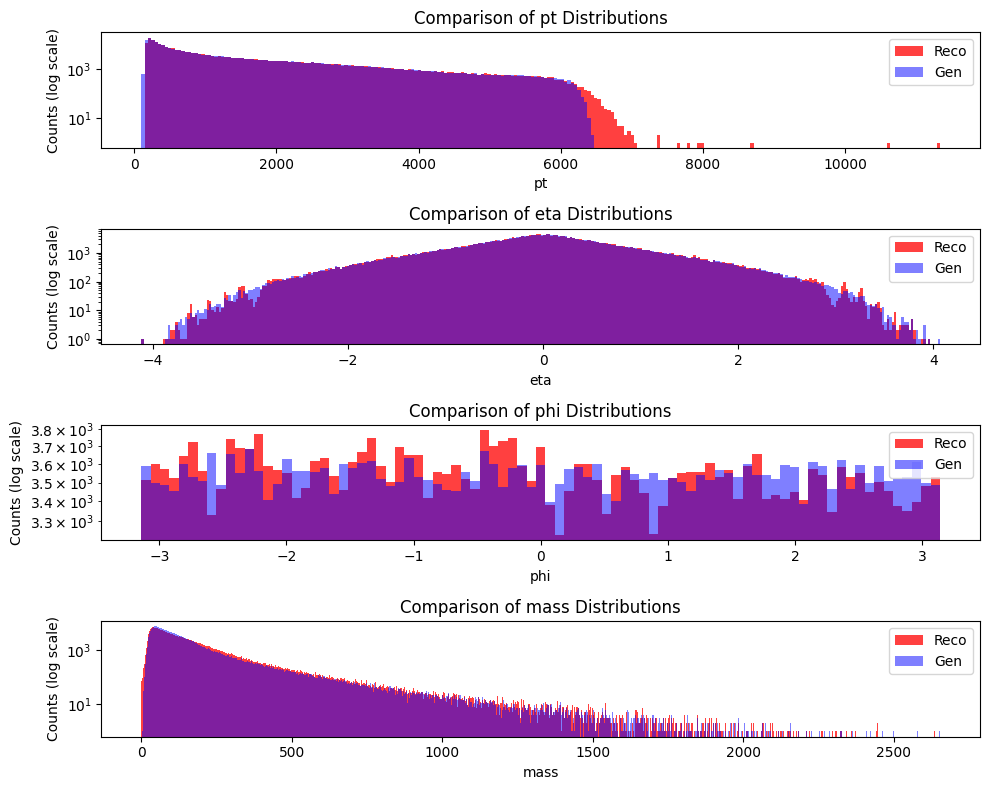

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Define all necessary functions...

def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(128, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Load data and preprocess...

qcd_mc = uproot.open('Data2.root')['Events']
fields = ['pt', 'eta', 'phi', 'mass']
jet_reco = {f: qcd_mc[f'FatJet_{f}'].array()[:, :1] for f in fields}
jet_gen = {f: qcd_mc[f'GenJetAK8_{f}'].array()[:, :1] for f in fields}

mask = (ak.num(jet_reco['pt'], axis=1) > 0) & (ak.num(jet_gen['pt'], axis=1) > 0)
for f in fields:
    jet_reco[f] = jet_reco[f][mask]
    jet_gen[f] = jet_gen[f][mask]

features = np.stack([ak.to_numpy(jet_gen['pt']).flatten(), ak.to_numpy(jet_gen['mass']).flatten()], axis=-1)
weights = np.ones(len(features))

# Build and compile the model...

model = build_model(input_dim=features.shape[1])

# Model training with early stopping and checkpointing...

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
]

X_train, X_test, Y_train, Y_test = train_test_split(features, np.zeros(len(features)), test_size=0.2)

history = model.fit(X_train, Y_train, epochs=20, batch_size=1000, validation_data=(X_test, Y_test), verbose=1, callbacks=callbacks)

# Visualization with improvements...

fig, axs = plt.subplots(len(fields), 1, figsize=(10, 8))

for i, prop in enumerate(fields):
    gen_data = ak.to_numpy(ak.flatten(jet_gen[prop]))
    reco_data = ak.to_numpy(ak.flatten(jet_reco[prop]))

    bins = np.histogram_bin_edges(np.hstack((reco_data, gen_data)), bins='auto')

    axs[i].hist(reco_data, bins=bins, alpha=0.75, label='Reco', color='red', log=True)
    axs[i].hist(gen_data, bins=bins, alpha=0.5, label='Gen', color='blue', log=True)

    axs[i].set_title(f'Comparison of {prop} Distributions')
    axs[i].set_xlabel(f'{prop}')
    axs[i].set_ylabel('Counts (log scale)')
    axs[i].legend()

plt.tight_layout()
plt.show()
